# Выбор локации для скважины

## Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Загрузка-и-подготовка-данных">Загрузка и подготовка данных</a></li>
    <li><a href="#Обучение-и-проверка-модели">Обучение и проверка модели</a></li>
    <li><a href="#Подготовка-к-расчёту-прибыли">Подготовка к расчёту прибыли</a></li>
    <li><a href="#Расчёт-прибыли-и-рисков">Расчёт прибыли и рисков</a></li>
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Построить модель для определения региона, где добыча принесёт наибольшую прибыль.

**Задачи**:
    
    1. Загрузить и подготовить данные.  
    
    2. Обучить и проверить модель для каждого региона.
        2.1 Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
        2.2 Обучить модель и сделать предсказания на валидационной выборке.
        2.3 Сохранить предсказания и правильные ответы на валидационной выборке.
        2.4 Напечатать средний запас предсказанного сырья и RMSE модели.
        2.5 Проанализировать результаты.
        
    3. Подготовить данные к расчёту прибыли.
        3.1 Все ключевые значения для расчётов сохранить в отдельных переменных.
        3.2 Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
        3.3 Написать выводы по этапу подготовки расчёта прибыли.
        
    4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.
        4.1 Выбрать скважины с максимальными значениями предсказаний.
        4.2 Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
        4.3 Рассчитайть прибыль для полученного объёма сырья.
        
    5. Посчитать риски и прибыль для каждого региона.
        5.1 Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
        5.2 Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков.

    6. Сделать выводы по итогам работы и предложить регион для разработки скважин.    
    
---
    
### Описание данных

- `id` — уникальный идентификатор скважины.
- `f0`, `f1`, `f2` — три признака точек.
- `product` — объём запасов в скважине (тыс. баррелей).

---

## Загрузка и подготовка данных

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [2]:
# Константы
TOTAL_BUDGET = 10**10 # Бюджет на разработку скважин в регионе
EXP_WELL = 500 # количество исследуемых скважин
WELL = 200 # количество реализуемых скважин
INCOME = 450 * 10**3 # доход с каждой единицы сырья

In [3]:
df1 = pd.read_csv("/datasets/geo_data_0.csv")
df2 = pd.read_csv("/datasets/geo_data_1.csv")
df3 = pd.read_csv("/datasets/geo_data_2.csv")

In [4]:
def data_view (data):
    data.info()
    display(data.head())
    print('Число дубликатов:', data.duplicated().sum())
    print('Пропуски:\n', data.isnull().sum())
    display(data.describe())
    print("Корреляция:")
    display(data.corr().style.background_gradient(axis=0))  

In [5]:
# 1 регион
data_view (df1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Число дубликатов: 0
Пропуски:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Корреляция:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [6]:
# 2 регион
data_view (df2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Число дубликатов: 0
Пропуски:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Корреляция:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [7]:
# 3 регион
data_view (df3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Число дубликатов: 0
Пропуски:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Корреляция:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


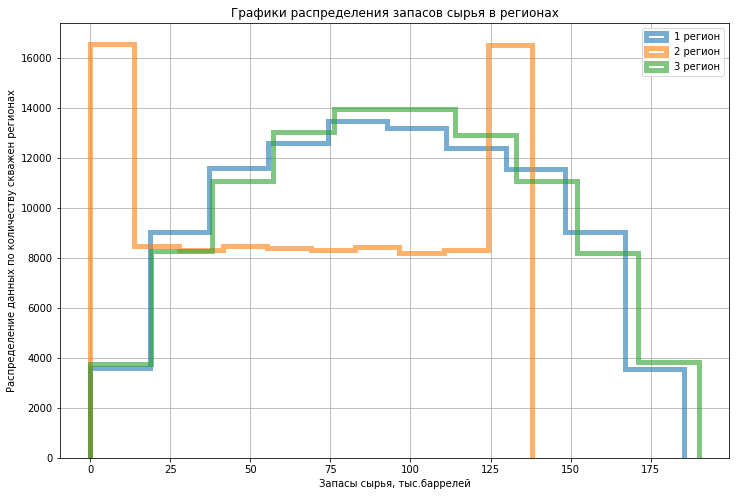

In [8]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.title('Графики распределения запасов сырья в регионах')
df1['product'].plot(kind='hist', grid=True, legend=True, alpha=0.6, histtype='step', linewidth=5, label='1 регион')
df2['product'].plot(kind='hist', grid=True, legend=True, alpha=0.6, histtype='step', linewidth=5, label='2 регион')
df3['product'].plot(kind='hist', grid=True, legend=True, alpha=0.6, histtype='step', linewidth=5, label='3 регион')
plt.xlabel('Запасы сырья, тыс.баррелей')
plt.ylabel('Распределение данных по количеству скважен регионах')
plt.show()

### Вывод
* Данные чистые, без пропусков и дубликатов.
* На графике показана отличающаяся кривая распределения запасов сырья по скважинам 2 региона.
* Так же в данных по корреляции значений второго регоина, мы видим сильную зависимость *product* от *f2*.

## Обучение и проверка модели

In [9]:
# обучение моделей
def model_line (data):
    target = data['product'] #целевой признак
    features = data.drop(['product', 'id'], axis=1) # признаки

    features_train, features_valid, target_train,target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=54321) # разбиваем на выборки

    model = LinearRegression().fit(features_train, target_train)# обучаем
    prediction_model = model.predict(features_valid) #прогноз
    
    rmse = mean_squared_error(target_valid, prediction_model)**0.5 # считаем rmse
    average_product = prediction_model.sum()/len(prediction_model) # прогнозируемые запасы

    return target_valid, prediction_model, rmse, average_product

In [10]:
target_valid_1, predicted_valid_1, rmse_1, average_product_1 = model_line(df1) 
target_valid_2, predicted_valid_2, rmse_2, average_product_2 = model_line(df2)
target_valid_3, predicted_valid_3, rmse_3, average_product_3 = model_line(df3)

In [11]:
comparison_tabl = pd.DataFrame(index=['Cредний запас предсказанного сырья','RMSE модели'], columns=['1 Регион','2 Регион','3 Регион'])
comparison_tabl['1 Регион'] = average_product_1, rmse_1
comparison_tabl['2 Регион'] = average_product_2, rmse_2
comparison_tabl['3 Регион'] = average_product_3, rmse_3
comparison_tabl

,1 Регион,2 Регион,3 Регион
Cредний запас предсказанного сырья,92.159212,68.445941,94.922295
RMSE модели,37.683411,0.892282,40.152505


### Вывод
* Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
* Модель обучена и сделаны предсказания на валидационной выборке. Предсказания и правильные ответы на валидационной выборке сохранены в соответстующих переменных.
* Модели обучены и проверены на качество предсказания метрикой RMSE. Исходя из полученных данных, можно заметить, что величина RMSE во втором регионе сильно отличается от других регионов, предположу, что модель обучилась на практически равных по величине данных, что видно из распределения данных на графике.

## Подготовка к расчёту прибыли

При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс.рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

Как я понял из условий, за 10 млд. руб. исследуют 500 точек, затем только в 200 из них добывают нефть

In [12]:
budget_per_1 = TOTAL_BUDGET/WELL
print("Каждая скважина должна заработать:", budget_per_1/1000 ,"млн.руб")

Каждая скважина должна заработать: 50000.0 млн.руб


In [13]:
extraction=budget_per_1/INCOME
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%extraction,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


In [14]:
comparison_tabl = pd.DataFrame(index=['Cредний запас предсказанного сырья','RMSE модели', "Объём для безубыточной разработки"], columns=['1 Регион','2 Регион','3 Регион'])
comparison_tabl['1 Регион'] = average_product_1, rmse_1, round(extraction, 2)
comparison_tabl['2 Регион'] = average_product_2, rmse_2, round(extraction, 2)
comparison_tabl['3 Регион'] = average_product_3, rmse_3, round(extraction, 2)
comparison_tabl

,1 Регион,2 Регион,3 Регион
Cредний запас предсказанного сырья,92.159212,68.445941,94.922295
RMSE модели,37.683411,0.892282,40.152505
Объём для безубыточной разработки,111.110000,111.110000,111.110000


In [15]:
print("Регион_1:")
display(df1.describe())
print("Регион_2:")
display(df2.describe())
print("Регион_3:")
display(df3.describe())

Регион_1:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Регион_2:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Регион_3:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [16]:
print("36% скважин в 1 регионе содержат больше сырья, чем ",
      round(df1["product"].quantile(0.64),2))
print("16% скважин в 2 регионе содержат больше сырья, чем ",
      round(df2["product"].quantile(0.84),2))
print("38% скважин в 3 регионе содержат больше сырья, чем ",
      round(df3["product"].quantile(0.62),2))

36% скважин в 1 регионе содержат больше сырья, чем  111.87
16% скважин в 2 регионе содержат больше сырья, чем  134.77
38% скважин в 3 регионе содержат больше сырья, чем  111.34


### Вывод
Исходя из полученных данных, средний запас сырья в каждом регионе ниже и недостаточен для безубыточной разработки новых скважин.

## Расчёт прибыли и рисков 

In [17]:
# метод для приведения к типу Series
def series_type(target, pred):
    target = target.reset_index(drop=True)
    pred = pd.Series(pred)
    return target, pred

In [18]:
# приведем целевые и прогнозные значения по всем регионам к одному типу
target_valid_1, predicted_valid_1 = series_type(target_valid_1, predicted_valid_1)
target_valid_2, predicted_valid_2 = series_type(target_valid_2, predicted_valid_2)
target_valid_3, predicted_valid_3 = series_type(target_valid_3, predicted_valid_3)

In [19]:
def revenue(target, probabilities, WELL, INCOME, TOTAL_BUDGET): 
    probs_sorted = probabilities.sort_values(ascending=False) # отсортировали по предсказанным объемам по убыванию
    selected = target[probs_sorted.index][:WELL] # отобрали диапазон (от 0 до WELL(200)) c отсортированными индексами
    return int(INCOME * selected.sum() - TOTAL_BUDGET) # суммарная прибыль = объемы, умножили на цену, минус инвестиции  

In [20]:
# Bootstrap с 1000 выборок
def bootstrap_mg (predicted_valid, target_valid, WELL, INCOME, TOTAL_BUDGET):
    values = []
    state = np.random.RandomState(54321)
    
    for i in range(1000):
        target_subsample = target_valid.sample(n=EXP_WELL, replace=True, random_state=state)
        predict_subsample = predicted_valid[target_subsample.index]
        values.append(revenue(target_subsample, predict_subsample, WELL, INCOME, TOTAL_BUDGET))
 
    
    values = pd.Series(values)
    lower = int(values.quantile(0.025))# ВОТ НИЖНИЙ КВАНТИЛЬ
    upper = int(values.quantile(0.975))# ВОТ ВЕРХНИЙ КВАНТИЛЬ
    risk = int(len(values[values < 0]) / len(values)* 1000)
    
    print('Ожидаемая средняя прибыль 200 скважин:', round (values.mean()/ 10**6, 2),' млн рублей') #переведем в млн для удобвства восприятие
    print('Верхняя граница 95%-го доверительного интервала:', round(upper/ 10**6, 2),' млн рублей')
    print('Нижняя граница 95%-го доверительного интервала:', round(lower/ 10**6, 2),' млн рублей')
    print('Риск потерь', round(risk, 2)/ 10, '%')
    
    return values, risk

In [21]:
values_1 , risk_1 = bootstrap_mg (predicted_valid_1, target_valid_1, WELL, INCOME, TOTAL_BUDGET)

Ожидаемая средняя прибыль 200 скважин: 408.96  млн рублей
Верхняя граница 95%-го доверительного интервала: 961.63  млн рублей
Нижняя граница 95%-го доверительного интервала: -96.36  млн рублей
Риск потерь 5.2 %


In [22]:
values_2 , risk_2 = bootstrap_mg (predicted_valid_2, target_valid_2, WELL, INCOME, TOTAL_BUDGET)

Ожидаемая средняя прибыль 200 скважин: 471.49  млн рублей
Верхняя граница 95%-го доверительного интервала: 911.49  млн рублей
Нижняя граница 95%-го доверительного интервала: 52.38  млн рублей
Риск потерь 1.2 %


In [23]:
values_3 , risk_3 = bootstrap_mg (predicted_valid_3, target_valid_3, WELL, INCOME, TOTAL_BUDGET)

Ожидаемая средняя прибыль 200 скважин: 420.9  млн рублей
Верхняя граница 95%-го доверительного интервала: 934.32  млн рублей
Нижняя граница 95%-го доверительного интервала: -140.32  млн рублей
Риск потерь 7.4 %


### Выбор региона и вывод

In [24]:
comparison_tabl = pd.DataFrame(index=['Средняя ожидаемая прибыль в регионе, млн.руб','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = round (values_1.mean()/ 10**6, 2), round(risk_1, 2)/ 10
comparison_tabl['2 регион'] = round (values_2.mean()/ 10**6, 2), round(risk_2, 2)/ 10
comparison_tabl['3 регион'] = round (values_3.mean()/ 10**6, 2), round(risk_3, 2)/ 10
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя ожидаемая прибыль в регионе, млн.руб",408.96,471.49,420.9
"Вероятность убытка, %",5.20,1.20,7.4


На основании полученных данных можно сделать вывод, что Регион 2 является наиболее привлекательным для разработки. Средняя прибыль в этом регионе составит 471.49 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%, что позволяют обосновать соответствующий выбор в пользу Региона 2.

## Общий вывод

* Предварительно изучил данные.
* Обучил модель *LinearRegression* и проверил ее качество метрикой *RMSE*.
* Вычислил объём сырья для безубыточной разработки новой скважины: 111.111 единицы продукта (тыс. баррелей)
* С помощью техники *Bootstrap* на 1000 выборок для с разделения каждого предсказанного значения прибыли по регионам.
* Исходя из данных и проведенного исследования, несмотря на то, что средний запас сырья во 2 Регионе значительно меньше остальных, другие регионы имеют значительный риск убытков превышающий 2.5%, что позволяет сделать выбор в пользу Региона 2 со средней ожидаемой прибылью 471.49 млн.рублей.